## 模型评价与验证
## 项目 1: 预测波士顿房价


>**Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

---
## 第一步. 导入数据
在这个项目中，我将利用马萨诸塞州波士顿郊区的房屋信息数据训练和测试一个模型，并对模型的性能和预测能力进行测试。通过该数据训练后的好的模型可以被用来对房屋做特定预测---尤其是对房屋的价值。对于房地产经纪等人的日常工作来说，这样的预测模型被证明非常有价值。

此项目的数据集来自[UCI机器学习知识库(数据集已下线)](https://archive.ics.uci.edu/ml/datasets.html)。波士顿房屋这些数据于1978年开始统计，共506个数据点，涵盖了麻省波士顿不同郊区房屋14种特征的信息。本项目对原始数据集做了以下处理：
- 有16个`'MEDV'` 值为50.0的数据点被移除。 这很可能是由于这些数据点包含**遗失**或**看不到的值**。
- 有1个数据点的 `'RM'` 值为8.78. 这是一个异常值，已经被移除。
- 对于本项目，房屋的`'RM'`， `'LSTAT'`，`'PTRATIO'`以及`'MEDV'`特征是必要的，其余不相关特征已经被移除。
- `'MEDV'`特征的值已经过必要的数学转换，可以反映35年来市场的通货膨胀效应。

运行下面区域的代码以载入波士顿房屋数据集，以及一些此项目所需的Python库。如果成功返回数据集的大小，表示数据集已载入成功。

In [1]:
# 载入此项目所需要的库
import numpy as np
import pandas as pd
# import visuals as vs # 导入本地名为visuals.py的文件代码，可用vs.方式调用其中的函数 也可把代码直接放到notebook内运行

# 检查Python版本
from sys import version_info
if version_info.major != 2 and version_info.minor != 7:
    raise Exception('需要使用Python 2.7来完成此项目')
    
# 让结果在notebook中显示
%matplotlib inline

In [6]:
%%time

# 用pandas载入波士顿房屋的数据集
data = pd.read_csv('housing.csv')
    
# 完成
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)

Boston housing dataset has 489 data points with 4 variables each.
Wall time: 3 ms


In [3]:
# 查看前五行数据
data.head()

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


In [4]:
# 快速了解数据的一些信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 4 columns):
RM         489 non-null float64
LSTAT      489 non-null float64
PTRATIO    489 non-null float64
MEDV       489 non-null float64
dtypes: float64(4)
memory usage: 15.4 KB


In [55]:
# 显示数据集数值属性的摘要，包括数据数量、均值、标准差、最小值、最大值等等
data.describe()

,RM,LSTAT,PTRATIO,MEDV
count,489.000000,489.000000,489.000000,4.890000e+02
mean,6.240288,12.939632,18.516564,4.543429e+05
std,0.643650,7.081990,2.111268,1.653403e+05
min,3.561000,1.980000,12.600000,1.050000e+05
25%,5.880000,7.370000,17.400000,3.507000e+05
50%,6.185000,11.690000,19.100000,4.389000e+05
75%,6.575000,17.120000,20.200000,5.187000e+05
max,8.398000,37.970000,22.000000,1.024800e+06


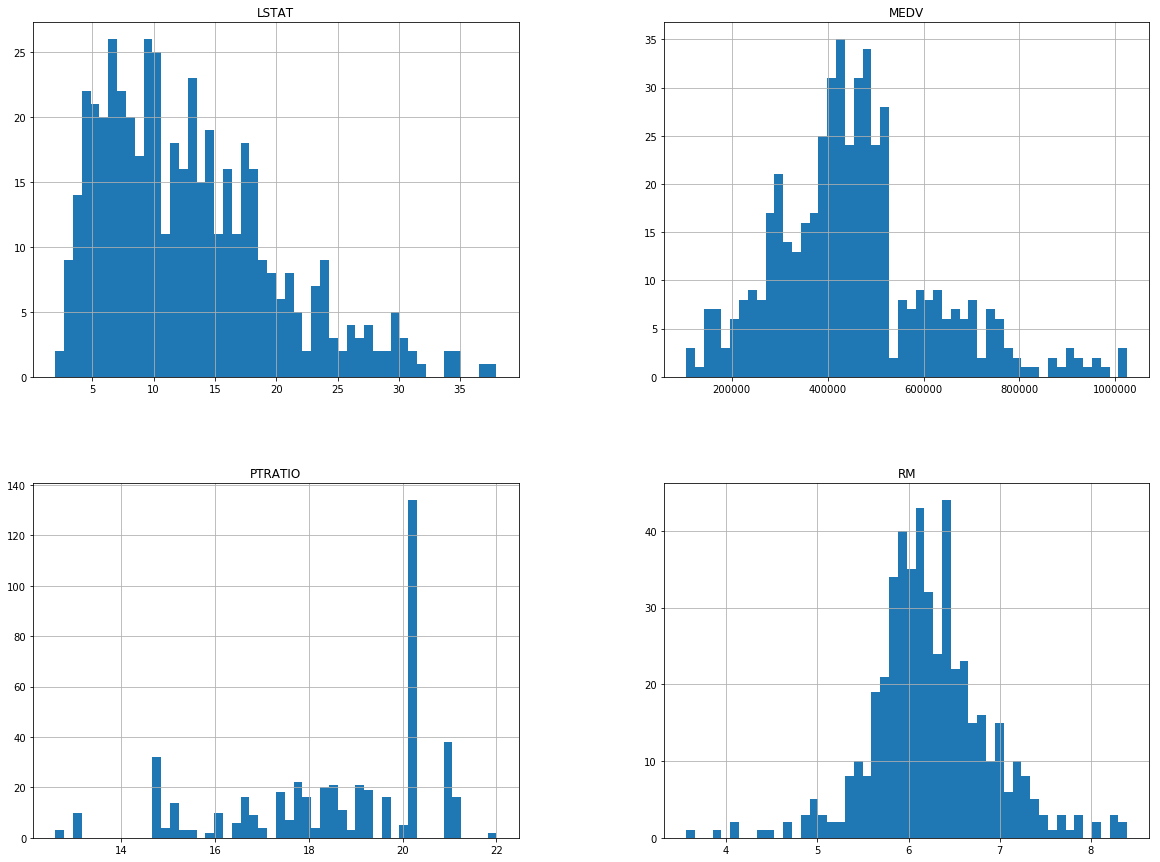

Wall time: 1.58 s


In [7]:
%%time

# 为数据集的每个数值绘制直方图 用data 调用 hist即可
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
%%time

# 计算 MEDV 与特征之间的皮尔逊相关系数
corr_matrix = data.corr()
corr_matrix["MEDV"].sort_values(ascending=False)

Wall time: 6 ms


Wall time: 1.94 s


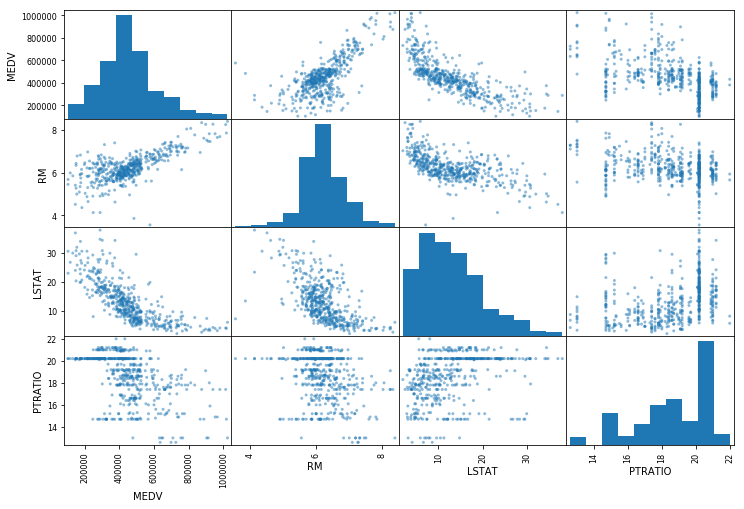

In [9]:
%%time

# 绘制属性之间的散布矩阵
from pandas.plotting import scatter_matrix
#from pandas.tools.plotting import scatter_matrix

attributes = ["MEDV", "RM", "LSTAT", "PTRATIO"]
scatter_matrix(data[attributes], figsize=(12, 8))

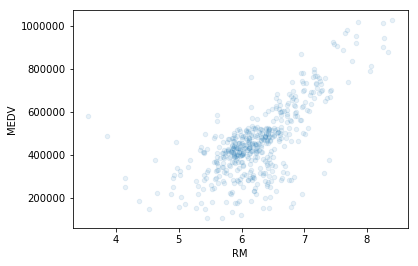

In [60]:
# 看起来 RM 与我们要预测的 MEDV 正相关，生成单独的相关图仔细观察
data.plot(kind="scatter", x="RM", y="MEDV", alpha=0.1)

In [10]:
# 把房屋价格MEDV这一列提取出来，作为需要预测的价格
prices = data['MEDV']

# 去掉房屋价格MEDV这一列，剩下的数据作为特征，用来进行预测
features = data.drop('MEDV', axis = 1)

In [6]:
# 显示前五条价格数据
prices.head()

0    504000.0
1    453600.0
2    728700.0
3    701400.0
4    760200.0
Name: MEDV, dtype: float64

In [7]:
# 显示前五条特征数据
features.head()

,RM,LSTAT,PTRATIO
0,6.575,4.98,15.3
1,6.421,9.14,17.8
2,7.185,4.03,17.8
3,6.998,2.94,18.7
4,7.147,5.33,18.7


---
## 第二步. 分析数据
对波士顿房地产数据进行初步的观察并给出分析。通过对数据的探索来熟悉数据可以更好地理解和解释结果。

由于这个项目的最终目标是建立一个预测房屋价值的模型，我们需要将数据集分为**特征(features)**和**目标变量(target variable)**。
- **特征** `'RM'`， `'LSTAT'`，和 `'PTRATIO'`，给我们提供了每个数据点的数量相关的信息。
- **目标变量**：` 'MEDV'`，是我们希望预测的变量。

他们分别被存在`features`和`prices`两个变量名中。

### 1：基础统计运算
计算有关波士顿房价的描述统计数据。使用` numpy `这个库来执行必要的计算。这些统计数据对于分析模型的预测结果是非常重要的。
下面的代码中需要：
- 计算`prices`中的`'MEDV'`的最小值、最大值、均值、中值和标准差；
- 将运算结果储存在相应的变量中。

In [11]:
%%time

# 计算价值的最小值
minimum_price = np.min(prices)

# 计算价值的最大值
maximum_price = np.max(prices)

# 计算价值的平均值
mean_price = np.mean(prices)

# 计算价值的中值
median_price = np.median(prices)

# 计算价值的标准差
std_price = np.std(prices)

#目标：输出计算的结果
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13
Wall time: 7 ms


### 特征观察

如前文所述，本项目中我们关注的是其中三个值:`'RM'`、`'LSTAT'` 和`'PTRATIO'`，对每一个数据点:
- `'RM'` 是该地区中每个房屋的平均房间数量；
- `'LSTAT'` 是指该地区有多少百分比的房东属于是低收入阶层（有工作但收入微薄）；
- `'PTRATIO'` 是该地区的中学和小学里，学生和老师的数目比（`学生/老师`）。

_凭直觉，上述三个特征中对每一个来说，增大该特征的数值，`'MEDV'`的值会是**增大**还是**减小**呢？_

如果'RM'增大，‘MEDV’会增大，因为房间数量增多表明房屋面积增大，因而房价应该更高。

如果'LSTAT'增大，‘MEDV’会减小，因为低收入房主百分比增加，说明地区收入水平不高，房价应该降低。

如果'PTRATIO'增大，‘MEDV’的变化不明显，比值的分子和分母都可能变化，不好预测。

### 2: 数据分割与重排
接下来，把波士顿房屋数据集分成训练和测试两个子集。通常在这个过程中，数据也会被重排列，以消除数据集中由于顺序而产生的偏差。

使用 `sklearn.model_selection` 中的 `train_test_split`， 将`features`和`prices`的数据都分成用于训练的数据子集和用于测试的数据子集。
  - 分割比例为：80%的数据用于训练，20%用于测试；
  - 选定一个数值以设定 `train_test_split` 中的 `random_state` ，这会确保结果的一致性；

In [12]:
%%time

# 导入train_test_split

"""打乱并分割数据为训练集和测试集"""

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=1)

Wall time: 605 ms


### 2 - 训练及测试
*将数据集按一定比例分为训练用的数据集和测试用的数据集对学习算法有什么好处？*

*如果果用模型已经见过的数据，例如部分训练集数据进行测试，又有什么坏处？*

---
## 第三步. 模型衡量标准
使用必要的模型衡量工具和技巧对每一个模型的表现做精确的衡量可以极大地增强预测的信心。

### 3：定义衡量标准
如果不能对模型的训练和测试的表现进行量化地评估，我们就很难衡量模型的好坏。通常我们会定义一些衡量标准，这些标准可以通过对某些误差或者拟合程度的计算来得到。在本项目中，我将通过计算[*决定系数*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination) R<sup>2</sup> 来量化模型的表现。模型的决定系数是回归分析中十分常用的统计信息，经常被当作衡量模型预测能力好坏的标准。

R<sup>2</sup>的数值范围从0至1，表示**目标变量**的预测值和实际值之间的相关程度平方的百分比。一个模型的R<sup>2</sup> 值为0还不如直接用**平均值**来预测效果好；而一个R<sup>2</sup> 值为1的模型则可以对目标变量进行完美的预测。从0至1之间的数值，则表示该模型中目标变量中有百分之多少能够用**特征**来解释。_模型也可能出现负值的R<sup>2</sup>，这种情况下模型所做预测有时会比直接计算目标变量的平均值差很多。_

在下方代码的 `performance_metric` 函数中：
- 使用 `sklearn.metrics` 中的 [`r2_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) 来计算 `y_true` 和 `y_predict`的R<sup>2</sup>值，作为对其表现的评判。
- 将他们的表现评分储存到`score`变量中。

或 

- 不使用任何外部库，参考[决定系数的定义](https://en.wikipedia.org/wiki/Coefficient_of_determination)进行计算，这也可以更好的理解决定系数在什么情况下等于0或等于1。

In [13]:
# 导入r2_score
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """计算r2分数"""    
    score = r2_score(y_true, y_predict)
    return score

In [ ]:
# 不使用任何外部库,用公式计算

def performance_metric(y_true, y_predict):
    """计算r2分数"""
    score = None #待补充 to be completed
    return score

---
## 第四步. 分析模型的表现
在项目的第四步，我们来看一下不同参数下，模型在训练集和验证集上的表现。这里，我们专注于一个特定的算法（带剪枝的决策树，但这并不是这个项目的重点），和这个算法的一个参数 `'max_depth'`。用全部训练集训练，选择不同`'max_depth'` 参数，观察这一参数的变化如何影响模型的表现。画出模型的表现来对于分析过程十分有益，这可以让我们看到一些单看结果看不到的行为。

### 学习曲线
下方区域内的代码会输出四幅图像，它们是一个决策树模型在不同最大深度下的表现。每一条曲线都直观得显示了随着训练数据量的增加，模型学习曲线的在训练集评分和验证集评分的变化，评分使用决定系数R<sup>2</sup>。曲线的阴影区域代表的是该曲线的不确定性（用标准差衡量）。

In [14]:
%%time

# 继续导入一些需要使用的库
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split

Wall time: 35 ms


In [15]:
# 根据不同的训练集大小和最大深度生成学习曲线
def ModelLearning(X, y):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and validation scores for each model are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 1)


    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = plt.figure(figsize=(15,30)) # 绘图窗口尺寸

    # Create three different models based on max_depth
    for k, depth in enumerate([1,2,3,4,5,6,7,8,9,10]):
        
        # Create a Decision tree regressor at max_depth = depth
        regressor = DecisionTreeRegressor(max_depth = depth)

        # Calculate the training and testing scores
        sizes, train_scores, valid_scores = learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')
        
        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        valid_std = np.std(valid_scores, axis = 1)
        valid_mean = np.mean(valid_scores, axis = 1)

        # Subplot the learning curve 
        ax = fig.add_subplot(5, 2, k+1) # 注意调节这里的数值，目前表示5行2列
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, valid_mean, 'o-', color = 'g', label = 'Validation Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, valid_mean - valid_std, \
            valid_mean + valid_std, alpha = 0.15, color = 'g')
        
        # Labels
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('r2_score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()

Wall time: 5.3 s


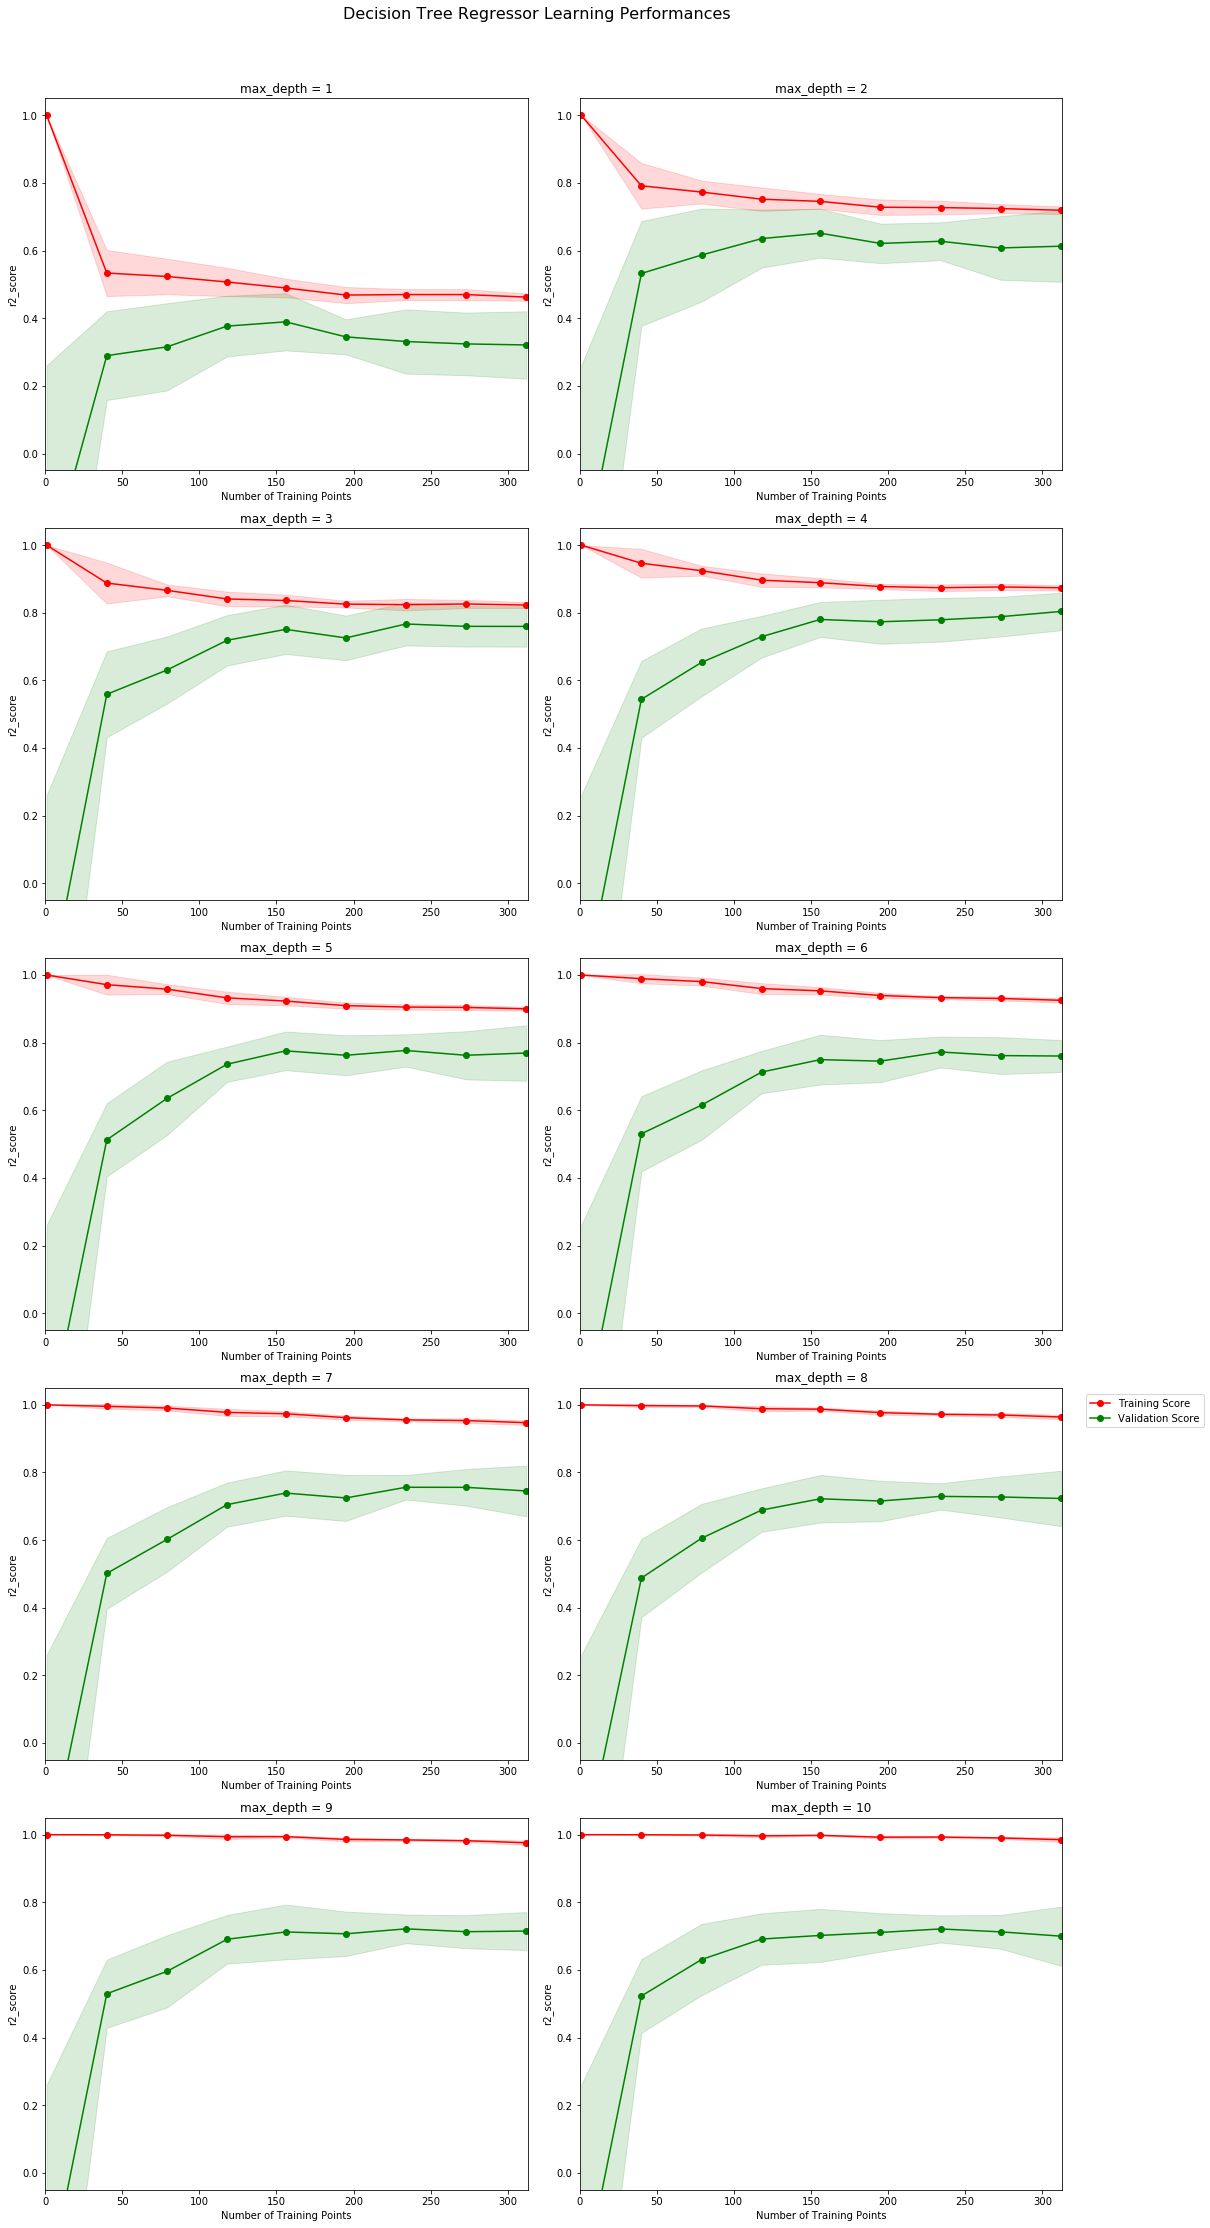

In [17]:
%%time

# 根据不同的训练集大小，和最大深度，生成决策树的学习曲线
ModelLearning(X_train, y_train)

### 复杂度曲线
下列代码内的区域会输出一幅图像，它展示了一个已经经过训练和验证的决策树模型在不同最大深度条件下的表现。这个图形将包含两条曲线，一个是训练集的变化，一个是验证集的变化。跟**学习曲线**相似，阴影区域代表该曲线的不确定性，模型训练和测试部分的评分都用的 `performance_metric` 函数。

In [20]:
# 根据不同的最大深度参数，生成复杂度曲线
def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and validation errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 1)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, valid_scores = validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Decision Tree Regressor Complexity Performance')
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(max_depth, valid_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, valid_mean - valid_std, \
        valid_mean + valid_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('r2_score')
    plt.ylim([-0.05,1.05])
    plt.show()

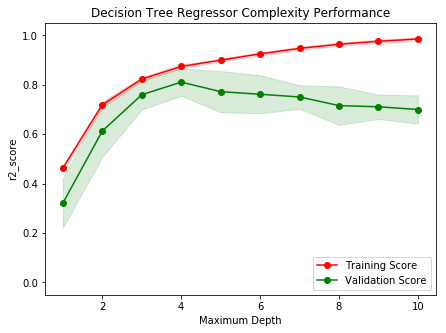

Wall time: 696 ms


In [21]:
%%time

# 根据不同的最大深度参数，生成复杂度曲线
ModelComplexity(X_train, y_train)

### 5 - 偏差（bias）与方差（variance）之间的权衡取舍

当模型以最大深度1训练时，模型出现很大偏差（bias），r2score不足0.4，因为模型复杂度太低；

当模型以最大深度10训练时，方差（variance）很大，这是因为模型过于适应训练集但泛化性较差，验证集得分低。

### 6- 最优模型的猜测

最大深度为4时模型预测性能最好。此时验证集得分最高，与训练集之间的差异也不大，如果深度增加，验证集得分下降，与训练集的差异也增大。

---
## 第五步. 选择最优参数

### 7- 网格搜索（Grid Search）
网格搜索法通常要用到交叉验证。针对给出的参数遍历多种参数的组合，用交叉验证方法得出每种参数组合的最终验证得分，再进行对比，选出验证分数最高的参数组合，即最优参数，采用最优参数的模型也就是最佳模型。

### 8 - 交叉验证
- 什么是K折交叉验证法（k-fold cross-validation）？
- [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)是如何结合交叉验证来完成对最佳参数组合的选择的？
- [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)中的`'cv_results_'`属性能告诉我们什么？
- 网格搜索时如果不使用交叉验证会有什么问题？交叉验证又是如何解决这个问题的？

在下面 fit_model函数最后加入 `print pd.DataFrame(grid.cv_results_)` 可以帮查看更多信息。

1.K折交叉验证法是指：将训练集的所有数据平均划分成K份，取第K份作为验证集，余下的K-1份作为交叉验证的训练集。然后执行K次训练，K次验证，让每一份数据集都发挥作用，得出K个验证分数，求其平均值得出最终验证分数。Kfold的默认参数是shuffle=False, random_state=None，表示不进行洗牌，但未给定随机数种子，我认为此时是按顺序切分。

2.采用GridSearchCV方法时，针对给出的参数遍历多种参数的组合，用交叉验证方法得出每种参数组合的最终验证得分，再进行对比，选出验证分数最高的参数组合，即最优参数，采用最优参数的模型也就是最佳模型。

3.GridSearchCV中的'cv_results_'属性是一个字典，内含多种参数，比如训练得分，测试得分等等。

4.网格搜索时如果不使用交叉验证，训练数据集的效用得不到充分发挥，因为在每种参数组合情况下只训练和验证一次，由此得出的参数组合的验证得分代表性不足，选出的最优参数组合和最佳模型未必最优。如果采用交叉验证，每种参数组合下都会进行K次训练和验证，可得出参数组合的平均验证得分（最终验证得分），这样才能找出最佳参数，进而得到最佳模型。

###  训练最优模型
使用**决策树算法**训练一个模型。为了得出最优模型，需要使用网格搜索法训练模型，以找到最佳的 `'max_depth'` 参数。可以把`'max_depth'` 参数理解为决策树算法在做出预测前，允许其对数据提出问题的数量。决策树是**监督学习算法**中的一种。

在下方 `fit_model` 函数中：
1. **定义 `'cross_validator'` 变量**: 使用 `sklearn.model_selection` 中的 [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) 创建一个交叉验证生成器对象;
2. **定义 `'regressor'` 变量**: 使用  `sklearn.tree` 中的 [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) 创建一个决策树的回归函数;
3. **定义 `'params'` 变量**: 为 `'max_depth'` 参数创造一个字典，它的值是从1至10的数组;
4. **定义 `'scoring_fnc'` 变量**: 使用 `sklearn.metrics` 中的 [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html)  创建一个评分函数；
 将 `‘performance_metric’` 作为参数传至这个函数中；
5. **定义 `'grid'` 变量**: 使用 `sklearn.model_selection` 中的 [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 创建一个网格搜索对象；将变量`'regressor'`, `'params'`, `'scoring_fnc'`和 `'cross_validator'` 作为参数传至这个对象构造函数中；
  
关于python函数的默认参数定义和传递，可以参考这个MIT课程的[视频](http://cn-static.udacity.com/mlnd/videos/MIT600XXT114-V004200_DTH.mp4)。

In [22]:
# 导入 'KFold' 'DecisionTreeRegressor' 'make_scorer' 'GridSearchCV' 
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_best_DecisionTreeRegressor(X, y): 
    """ 基于输入数据 [X,y]，利于网格搜索找到最优的决策树模型"""
    
    cross_validator = KFold(n_splits=10, random_state=1, shuffle=True)
    
    regressor = DecisionTreeRegressor()

    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}

    scoring_fnc = make_scorer(performance_metric)

    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cross_validator)

    # 基于输入数据 [X,y]，进行网格搜索
    grid = grid.fit(X, y)
    
    #print pd.DataFrame(grid.cv_results_) # 显示更多信息

    # 返回网格搜索后的最优模型
    return grid.best_estimator_

### 9 - 最优模型
运行下方区域内的代码，将决策树回归函数代入训练数据的集合，以得到最优化的模型。

In [24]:
%%time

# 基于训练数据，获得最优回归模型
optimal_DecisionTreeRegressor = fit_best_DecisionTreeRegressor(X_train, y_train)

# 输出最优模型的 'max_depth' 参数
print "Parameter 'max_depth' is {} for the optimal model.".format(optimal_DecisionTreeRegressor.get_params()['max_depth'])

Parameter 'max_depth' is 4 for the optimal model.
Wall time: 624 ms


In [25]:
# 查看最佳模型的参数
optimal_DecisionTreeRegressor.get_params()

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [27]:
%%time

# 用测试集数据计算各种回归评价指标

predicted_price_DecisionTreeRegressor = optimal_DecisionTreeRegressor.predict(X_test)

from sklearn.metrics import r2_score
r2_DecisionTreeRegressor = r2_score(y_test, predicted_price_DecisionTreeRegressor)
print "Optimal Decision Tree Regressor has R^2 score {:,.2f} on test data".format(r2_DecisionTreeRegressor)

from sklearn.metrics import explained_variance_score
# Best possible score is 1.0, lower values are worse
explained_variance_score_DecisionTreeRegressor = explained_variance_score(y_test, predicted_price_DecisionTreeRegressor)
print "Optimal Decision Tree Regressor has explained variance score {:,.2f} on test data".format(explained_variance_score_DecisionTreeRegressor)

from sklearn.metrics import mean_absolute_error
mean_absolute_error_DecisionTreeRegressor = mean_absolute_error(y_test, predicted_price_DecisionTreeRegressor)
print "Optimal Decision Tree Regressor has mean absolute error {:,.2f} on test data".format(mean_absolute_error_DecisionTreeRegressor)

from sklearn.metrics import mean_squared_error
mean_squared_error_DecisionTreeRegressor = mean_squared_error(y_test, predicted_price_DecisionTreeRegressor)
print "Optimal Decision Tree Regressor has mean squared error {:,.2f} on test data".format(mean_squared_error_DecisionTreeRegressor)

from sklearn.metrics import median_absolute_error
median_absolute_error_DecisionTreeRegressor = median_absolute_error(y_test, predicted_price_DecisionTreeRegressor)
print "Optimal Decision Tree Regressor has median absolute error {:,.2f} on test data".format(median_absolute_error_DecisionTreeRegressor)

Optimal Decision Tree Regressor has R^2 score 0.78 on test data
Optimal Decision Tree Regressor has explained variance score 0.78 on test data
Optimal Decision Tree Regressor has mean absolute error 52,717.17 on test data
Optimal Decision Tree Regressor has mean squared error 6,050,132,389.90 on test data
Optimal Decision Tree Regressor has median absolute error 37,192.56 on test data
Wall time: 8 ms


In [9]:
# 生成决策树可视化图形 dot 文件
from sklearn.tree import export_graphviz
export_graphviz(optimal_DecisionTreeRegressor,
               out_file="boston_housing_decision_tree.dot",
               feature_names=["RM","LSTAT","PTRATIO"]
               )

In [2]:
# 将dot转换成png文件
import pydot
(graph,) = pydot.graph_from_dot_file('boston_housing_decision_tree.dot')
graph.write_png('boston_housing_decision_tree.png')


#from subprocess import check_call
#check_call(['dot','-Tpng','boston_housing_decision_tree.dot','-o','boston_housing_decision_tree.png'])
#上述代码没成功，报错

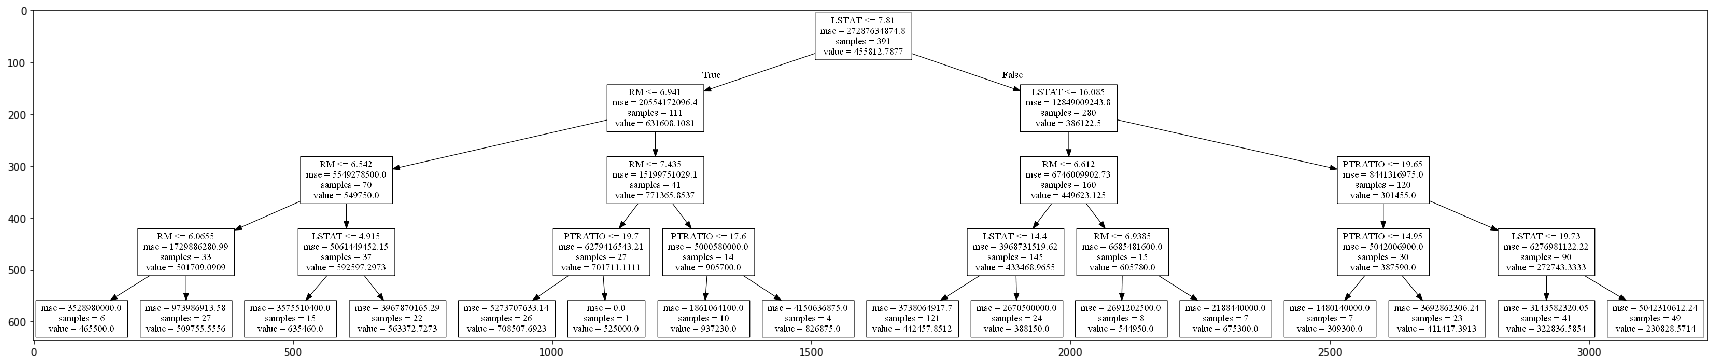

In [10]:
#import matplotlib.image as mpimg
#tree_graph = mpimg.imread("boston_housing_decision_tree.png") # 这里读取后，即为numpy格式  

from PIL import Image
tree_graph = Image.open("boston_housing_decision_tree.png") #另一种读取方式

import matplotlib.pyplot as plt 
#plt.imshow(tree_graph, interpolation='nearest', aspect='auto')

plt.figure(figsize=(30,40)) #设定绘图尺寸
plt.imshow(tree_graph)

## 采用随机森林回归尝试

In [28]:
# 定义一个寻找最佳随机森林回归器的函数

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_best_RandomForestRegressor(X, y): 
    """ 基于输入数据 [X,y]，利于网格搜索找到最优的随机森林回归模型"""
    
    cross_validator = KFold(n_splits=10, random_state=1, shuffle=True)
    
    #随机森林回归器
    regressor = RandomForestRegressor(max_features='auto', n_jobs=-1, oob_score=False, random_state=1, verbose=0, warm_start=False)
    
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10],
             'n_estimators':[500,600,700]}

    scoring_fnc = make_scorer(performance_metric)

    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cross_validator)

    # 基于输入数据 [X,y]，进行网格搜索
    grid = grid.fit(X, y)
    
    #print pd.DataFrame(grid.cv_results_) # 显示更多信息

    # 返回网格搜索后的最优模型
    return grid.best_estimator_

In [29]:
%%time

# 基于训练数据，获得最优回归模型
optimal_RandomForestRegressor = fit_best_RandomForestRegressor(X_train, y_train)

Wall time: 23min 7s


In [30]:
# 查看最佳模型的参数
optimal_RandomForestRegressor.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [31]:
%%time

predicted_price_RandomForestRegressor = optimal_RandomForestRegressor.predict(X_test)

# 用测试集数据计算各种回归评价指标

#from sklearn.metrics import r2_score
r2_RandomForestRegressor = r2_score(y_test, predicted_price_RandomForestRegressor)
print "Optimal RandomForestRegressor has R^2 score {:,.2f} on test data".format(r2_RandomForestRegressor)

#from sklearn.metrics import explained_variance_score
# Best possible score is 1.0, lower values are worse
explained_variance_score_RandomForestRegressor = explained_variance_score(y_test, predicted_price_RandomForestRegressor)
print "Optimal RandomForestRegressor has explained variance score {:,.2f} on test data".format(explained_variance_score_RandomForestRegressor)

#from sklearn.metrics import mean_absolute_error
mean_absolute_error_RandomForestRegressor = mean_absolute_error(y_test, predicted_price_RandomForestRegressor)
print "Optimal RandomForestRegressor has mean absolute error {:,.2f} on test data".format(mean_absolute_error_RandomForestRegressor)

#from sklearn.metrics import mean_squared_error
mean_squared_error_RandomForestRegressor = mean_squared_error(y_test, predicted_price_RandomForestRegressor)
print "Optimal RandomForestRegressor has mean squared error {:,.2f} on test data".format(mean_squared_error_RandomForestRegressor)

#from sklearn.metrics import median_absolute_error
median_absolute_error_RandomForestRegressor = median_absolute_error(y_test, predicted_price_RandomForestRegressor)
print "Optimal RandomForestRegressor has median absolute error {:,.2f} on test data".format(median_absolute_error_RandomForestRegressor)

Optimal RandomForestRegressor has R^2 score 0.83 on test data
Optimal RandomForestRegressor has explained variance score 0.83 on test data
Optimal RandomForestRegressor has mean absolute error 48,776.95 on test data
Optimal RandomForestRegressor has mean squared error 4,673,922,759.77 on test data
Optimal RandomForestRegressor has median absolute error 37,469.92 on test data
Wall time: 748 ms


## 用AdaBoost 尝试

In [37]:
from sklearn.ensemble import AdaBoostRegressor

def fit_best_AdaBoostRegressor(X, y): 
    """ 基于输入数据 [X,y]，利于网格搜索找到最优的AdaBoost回归模型"""
    
    cross_validator = KFold(n_splits=10, random_state=1, shuffle=True)
    
    #AdaBoost回归器
    regressor = AdaBoostRegressor(random_state=1)
    
    params = {'learning_rate':[0.001,0.003,0.005,0.007,0.009,0.01,0.03,0.05,0.07,0.09,0.1,0.5,1],
             'n_estimators':[100,200,300,400,500,600,700,800]}

    scoring_fnc = make_scorer(performance_metric)

    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cross_validator)

    # 基于输入数据 [X,y]，进行网格搜索
    grid = grid.fit(X, y)
    
    #print pd.DataFrame(grid.cv_results_) # 显示更多信息

    # 返回网格搜索后的最优模型
    return grid.best_estimator_

In [38]:
%%time

# 基于训练数据，获得最优回归模型
optimal_AdaBoostRegressor = fit_best_AdaBoostRegressor(X_train, y_train)

Wall time: 20min 9s


In [39]:
# 查看最佳模型的参数
optimal_AdaBoostRegressor.get_params()

{'base_estimator': None,
 'learning_rate': 0.01,
 'loss': 'linear',
 'n_estimators': 500,
 'random_state': 1}

In [40]:
%%time

predicted_price_AdaBoostRegressor = optimal_AdaBoostRegressor.predict(X_test)

# 用测试集数据计算各种回归评价指标

#from sklearn.metrics import r2_score
r2_AdaBoostRegressor = r2_score(y_test, predicted_price_AdaBoostRegressor)
print "Optimal AdaBoostRegressor has R^2 score {:,.2f} on test data".format(r2_AdaBoostRegressor)

#from sklearn.metrics import explained_variance_score
# Best possible score is 1.0, lower values are worse
explained_variance_score_AdaBoostRegressor = explained_variance_score(y_test, predicted_price_AdaBoostRegressor)
print "Optimal AdaBoostRegressor has explained variance score {:,.2f} on test data".format(explained_variance_score_AdaBoostRegressor)

#from sklearn.metrics import mean_absolute_error
mean_absolute_error_AdaBoostRegressor = mean_absolute_error(y_test, predicted_price_AdaBoostRegressor)
print "Optimal AdaBoostRegressor has mean absolute error {:,.2f} on test data".format(mean_absolute_error_AdaBoostRegressor)

#from sklearn.metrics import mean_squared_error
mean_squared_error_AdaBoostRegressor = mean_squared_error(y_test, predicted_price_AdaBoostRegressor)
print "Optimal AdaBoostRegressor has mean squared error {:,.2f} on test data".format(mean_squared_error_AdaBoostRegressor)

#from sklearn.metrics import median_absolute_error
median_absolute_error_AdaBoostRegressor = median_absolute_error(y_test, predicted_price_AdaBoostRegressor)
print "Optimal AdaBoostRegressor has median absolute error {:,.2f} on test data".format(median_absolute_error_AdaBoostRegressor)

Optimal AdaBoostRegressor has R^2 score 0.79 on test data
Optimal AdaBoostRegressor has explained variance score 0.80 on test data
Optimal AdaBoostRegressor has mean absolute error 54,150.11 on test data
Optimal AdaBoostRegressor has mean squared error 5,777,380,248.38 on test data
Optimal AdaBoostRegressor has median absolute error 41,673.27 on test data
Wall time: 40 ms


## 采用GradientBoostingRegressor 尝试

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

def fit_best_GradientBoostingRegressor(X, y): 
    """ 基于输入数据 [X,y]，利于网格搜索找到最优的GradientBoosting回归模型"""
    
    cross_validator = KFold(n_splits=10, random_state=1, shuffle=True)
    
    #AdaBoost回归器
    regressor = GradientBoostingRegressor(loss = 'huber', random_state=1)
    
    params = {'learning_rate':[0.001,0.003,0.005,0.007,0.009,0.01,0.03,0.05,0.07,0.09,0.1,0.5,1],
             'n_estimators':[100,200,300,400,500,600,700,800],#The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
             }

    scoring_fnc = make_scorer(performance_metric)

    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cross_validator)

    # 基于输入数据 [X,y]，进行网格搜索
    grid = grid.fit(X, y)
    
    #print pd.DataFrame(grid.cv_results_) # 显示更多信息

    # 返回网格搜索后的最优模型
    return grid.best_estimator_

In [42]:
%%time

# 基于训练数据，获得最优回归模型
optimal_GradientBoostingRegressor = fit_best_GradientBoostingRegressor(X_train, y_train)

Wall time: 8min 59s


In [43]:
# 查看最佳模型的参数
optimal_GradientBoostingRegressor.get_params()

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.01,
 'loss': 'huber',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'presort': 'auto',
 'random_state': 1,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

In [44]:
%%time

predicted_price_GradientBoostingRegressor = optimal_GradientBoostingRegressor.predict(X_test)

# 用测试集数据计算各种回归评价指标

#from sklearn.metrics import r2_score
r2_GradientBoostingRegressor = r2_score(y_test, predicted_price_GradientBoostingRegressor)
print "Optimal GradientBoostingRegressor has R^2 score {:,.2f} on test data".format(r2_GradientBoostingRegressor)

#from sklearn.metrics import explained_variance_score
# Best possible score is 1.0, lower values are worse
explained_variance_score_GradientBoostingRegressor = explained_variance_score(y_test, predicted_price_GradientBoostingRegressor)
print "Optimal GradientBoostingRegressor has explained variance score {:,.2f} on test data".format(explained_variance_score_GradientBoostingRegressor)

#from sklearn.metrics import mean_absolute_error
mean_absolute_error_GradientBoostingRegressor = mean_absolute_error(y_test, predicted_price_GradientBoostingRegressor)
print "Optimal GradientBoostingRegressor has mean absolute error {:,.2f} on test data".format(mean_absolute_error_GradientBoostingRegressor)

#from sklearn.metrics import mean_squared_error
mean_squared_error_GradientBoostingRegressor = mean_squared_error(y_test, predicted_price_GradientBoostingRegressor)
print "Optimal GradientBoostingRegressor has mean squared error {:,.2f} on test data".format(mean_squared_error_GradientBoostingRegressor)

#from sklearn.metrics import median_absolute_error
median_absolute_error_GradientBoostingRegressor = median_absolute_error(y_test, predicted_price_GradientBoostingRegressor)
print "Optimal GradientBoostingRegressor has median absolute error {:,.2f} on test data".format(median_absolute_error_GradientBoostingRegressor)

Optimal GradientBoostingRegressor has R^2 score 0.83 on test data
Optimal GradientBoostingRegressor has explained variance score 0.84 on test data
Optimal GradientBoostingRegressor has mean absolute error 48,457.45 on test data
Optimal GradientBoostingRegressor has mean squared error 4,513,570,065.43 on test data
Optimal GradientBoostingRegressor has median absolute error 36,640.48 on test data
Wall time: 6 ms


## 综合上述指标，GradientBoostingRegressor的表现最好。

## 第六步. 做出预测
当我们用数据训练出一个模型，它现在就可用于对新的数据进行预测。在决策树回归函数中，模型已经学会对新输入的数据*提问*，并返回对**目标变量**的预测值。我们可以用这个预测来获取数据未知目标变量的信息，这些数据必须是不包含在训练数据之内的。

###  预测销售价格
想像自己是一个在波士顿地区的房屋经纪人，并期待使用此模型以帮助你的客户评估他们想出售的房屋。我已经从三个客户收集到以下资讯:

| 特征 | 客戶 1 | 客戶 2 | 客戶 3 |
| :---: | :---: | :---: | :---: |
| 房屋内房间总数 | 5 间房间 | 4 间房间 | 8 间房间 |
| 社区贫困指数（％被认为是贫困阶层） | 17% | 32% | 3% |
| 邻近学校的学生-老师比例 | 15：1 | 22：1 | 12：1 |

运行下列的代码区域，使用优化的模型来为每位客户的房屋价值做出预测。

In [47]:
%%time
# 生成三个客户的数据
client_data = [[5, 17, 15], # 客户 1
               [4, 32, 22], # 客户 2
               [8, 3, 12]]  # 客户 3

# 进行预测
predicted_price = optimal_GradientBoostingRegressor.predict(client_data)
for i, price in enumerate(predicted_price):
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)

Predicted selling price for Client 1's home: $338,299.69
Predicted selling price for Client 2's home: $253,707.43
Predicted selling price for Client 3's home: $895,514.39
Wall time: 2 ms


In [48]:
%%time
# 对整个测试集的预测结果
optimal_GradientBoostingRegressor.predict(X_test)

Wall time: 2 ms


array([ 313738.23852343,  415315.20769538,  461402.08743897,
        918254.44563782,  443945.84839532,  456946.71552503,
        321770.40440007,  509800.47931406,  280604.80018098,
        486118.04562278,  439318.15370561,  543547.62840598,
        449531.54134104,  527136.34282156,  216118.58697831,
        373929.58783653,  491934.38678678,  447277.93884291,
        523788.27261959,  637552.79119797,  441636.30160019,
        409960.46515256,  250934.41704766,  549451.44436097,
        710621.73802965,  372021.55595111,  360473.29971349,
        299102.62141315,  343405.59472515,  430805.8510518 ,
        674048.24665308,  604148.56574012,  655794.50638828,
        677897.19927868,  523959.47446048,  501221.55805066,
        511263.84172484,  501221.55805066,  828412.38286815,
        445386.98109783,  328637.29516131,  409964.80907285,
        257557.29654889,  445873.98403357,  265439.26352488,
        428240.14582423,  490080.14750896,  495312.81140308,
        509589.01233076,

In [49]:
# 对某一行数据进行预测，注意输出的数据格式，输出的是由一个数字构成的数组
optimal_GradientBoostingRegressor.predict(client_data[0])

d:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 338299.69429474])

In [50]:
# 对某一行数据进行预测，注意输出的数据格式，输出的是一个数字
optimal_GradientBoostingRegressor.predict(client_data[0])[0]

d:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


338299.69429473969

## 生成模型的复杂度曲线

In [53]:
# 根据不同的最大深度参数，生成复杂度曲线
def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and validation errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 1)

    # varying range of the number of estimators
    num_estimators = np.arange(100,800)

    # Calculate the training and testing scores
    train_scores, valid_scores = validation_curve(GradientBoostingRegressor(learning_rate=0.01), X, y, \
        param_name = "n_estimators", param_range = num_estimators, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Gradient Boosting Regressor Complexity Performance')
    plt.plot(num_estimators, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(num_estimators, valid_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(num_estimators, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(num_estimators, valid_mean - valid_std, \
        valid_mean + valid_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('number of estimators')
    plt.ylabel('r2_score')
    plt.ylim([-0.05,1.05])
    plt.show()

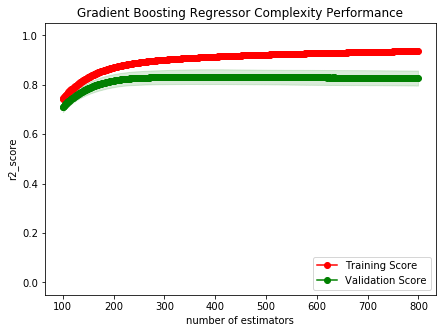

Wall time: 17min 50s


In [54]:
%%time

# 根据不同的梯度提升步骤参数，生成复杂度曲线
ModelComplexity(X_train, y_train)